#Ubermodel

In [1]:
import random as rd
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

#submit = True
submit = False

In [2]:
# Load data

#From Kaggle competition:
#k_train = pd.read_csv('../input/digit-recognizer/train.csv')
#k_train = pd.read_csv('../content/train.csv')
k_train = pd.read_csv('https://github.com/davidabelin/kaggle-files/raw/main/digit-recognizer/train.csv')
kaggle_data = [list(k_train.iloc[idx]) for idx in k_train.index]

# the public MNIST dataset.
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test.reshape((10000, 784))
x_train = x_train.reshape((60000, 784))

dummy = []
for i in range(len(x_test)):
    line = list(x_test[i])
    line.insert(0, int(y_test[i]))
    dummy += line
for i in range(len(x_train)):  
    line = list(x_train[i])
    line.insert(0, int(y_train[i]))
    dummy += line  
mnist_data = np.asarray(dummy).reshape((70000,785))
mnist_data = [list(row) for row in mnist_data]

all_data = mnist_data + kaggle_data

11493376/11490434 [==============================] - 0s 0us/step


In [46]:
all_data = np.random.permutation(all_data)
all_data = np.asarray(all_data)
data_df = pd.DataFrame(all_data)

data_0_norm, labels_0 = np.asarray(data_df.loc[0:19999, 1:]/255.), np.array(data_df.loc[0:19999,0])
data_1_norm, labels_1 = np.asarray(data_df.loc[20000:39999, 1:]/255.), np.array(data_df.loc[20000:39999,0])
data_2_norm, labels_2 = np.asarray(data_df.loc[40000:59999, 1:]/255.), np.array(data_df.loc[40000:59999,0])
val_data_norm, val_labels = np.asarray(data_df.loc[60000:61999:, 1:]/255.), np.array(data_df.loc[60000:61999,0])
uber_data_norm, uber_labels = np.asarray(data_df.loc[62000:, 1:]/255.), np.array(data_df.loc[62000:,0])

data_0_norm = data_0_norm.reshape(20000, 28, 28, 1)
data_1_norm = data_1_norm.reshape(20000, 28, 28, 1)
data_2_norm = data_2_norm.reshape(20000, 28, 28, 1)
val_data_norm = val_data_norm.reshape(2000, 28, 28, 1)
uber_data_norm = uber_data_norm.reshape(50000, 28, 28, 1)

In [47]:
# train on the training set with some held back for validation #
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=None, verbose=0):

    history = model.fit(x=train_features, y=train_label, 
                        batch_size=batch_size,
                        epochs=epochs, shuffle=True, 
                        validation_split=validation_split,
                        verbose = verbose)

    # Gather the model's metrics after each round of training
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [48]:
 # Set up a CNN with Keras
 
def create_CNN(learning_rate):
    """Create and compile a convolutional neural net."""  
    # Define the kind of model to use.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 5, activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model

In [49]:
def create_mixedNN(learning_rate):
    """Create and compile a deep neural net."""  
    # Define the kind of model to use.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 6, activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(64, 2, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units=512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model

In [50]:
def getDNNModel(learning_rate):
    inputs = keras.Input(shape=(28, 28, 1))
    dnn = layers.Flatten()(inputs)
    dnn = layers.Dense(768, activation='relu')(dnn)
    dnn = layers.Dropout(0.3)(dnn)
    dnn = layers.Dense(units=512, activation='relu')(dnn)
    dnn = layers.Dropout(0.2)(dnn)
    dnn = layers.Dense(units=256, activation='relu')(dnn)
    dnn = layers.Dropout(0.1)(dnn)
    outputs = layers.Dense(10, activation="softmax")(dnn)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model    

In [70]:
learning_rate = 0.001
epochs = 30
batch_size = 500

if submit:
    validation_split = None
    verbose = 0
else:
    validation_split = 0.05 # off bottom
    verbose = 1

model_A = create_CNN(learning_rate)
model_B = getDNNModel(learning_rate)
model_C = create_mixedNN(learning_rate)

In [71]:
#x_test_norm:
start_time = time.time()
epochs_A, hist_A = train_model(model_A, uber_data_norm, uber_labels, epochs, batch_size, validation_split, verbose=verbose)
if not submit:
    print("\nTrained model A in about {} seconds\n".format((round(time.time()-start_time,4))))
batch_time = time.time()

#x_train_norm:
epochs_B, hist_B = train_model(model_B, uber_data_norm, uber_labels, epochs, batch_size, validation_split, verbose=verbose)
if not submit:
    print("\nTrained model B in about {} seconds\n".format((round(time.time()-batch_time,4))))
batch_time = time.time()

#k_train_norm:
epochs_C, hist_C = train_model(model_C, uber_data_norm, uber_labels, epochs, batch_size, validation_split, verbose=verbose)
if not submit:
    print("\nTrained model C in about {} seconds\n".format((round(time.time()-batch_time,4))))

if not submit:
    print ("\nTotal time: {} seconds is about {} minutes.".format(round(time.time()-start_time,4),
                                                              (time.time()-start_time)//60))

Epoch 1/30
95/95 [==============================] - 0s 5ms/step - loss: 0.6548 - accuracy: 0.8315 - val_loss: 0.1876 - val_accuracy: 0.9472
Epoch 2/30
95/95 [==============================] - 0s 4ms/step - loss: 0.1366 - accuracy: 0.9601 - val_loss: 0.1074 - val_accuracy: 0.9676
Epoch 3/30
95/95 [==============================] - 0s 4ms/step - loss: 0.0890 - accuracy: 0.9738 - val_loss: 0.0906 - val_accuracy: 0.9692
Epoch 4/30
95/95 [==============================] - 0s 4ms/step - loss: 0.0684 - accuracy: 0.9800 - val_loss: 0.0625 - val_accuracy: 0.9804
Epoch 5/30
95/95 [==============================] - 0s 4ms/step - loss: 0.0578 - accuracy: 0.9831 - val_loss: 0.0693 - val_accuracy: 0.9764
Epoch 6/30
95/95 [==============================] - 0s 4ms/step - loss: 0.0497 - accuracy: 0.9851 - val_loss: 0.0512 - val_accuracy: 0.9840
Epoch 7/30
95/95 [==============================] - 0s 4ms/step - loss: 0.0436 - accuracy: 0.9869 - val_loss: 0.0502 - val_accuracy: 0.9840
Epoch 8/30
95/95 [==

In [72]:
if not submit:
    print ("Evaluate against val_data_norm:")
    print ("A:",model_A.evaluate(val_data_norm, val_labels, batch_size=100))
    print ("B:",model_B.evaluate(val_data_norm, val_labels, batch_size=100))
    print ("C:",model_C.evaluate(val_data_norm, val_labels, batch_size=100))

Evaluate against val_data_norm:
20/20 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.9905
A: [0.03670591488480568, 0.9904999732971191]
20/20 [==============================] - 0s 2ms/step - loss: 0.0638 - accuracy: 0.9900
B: [0.06384072452783585, 0.9900000095367432]
20/20 [==============================] - 0s 2ms/step - loss: 0.0407 - accuracy: 0.9915
C: [0.04066876694560051, 0.9915000200271606]


In [73]:
def getUberModel(learning_rate, modelA, modelB, modelC):
    
    inputs = keras.Input(shape=(28, 28, 1))
    xA = modelA(inputs)
    xB = modelB(inputs)
    xC = modelC(inputs)
    x = layers.concatenate([xA, xB, xC])
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
    ensemble_model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                            loss="sparse_categorical_crossentropy",
                            metrics=['accuracy']) 
    return ensemble_model

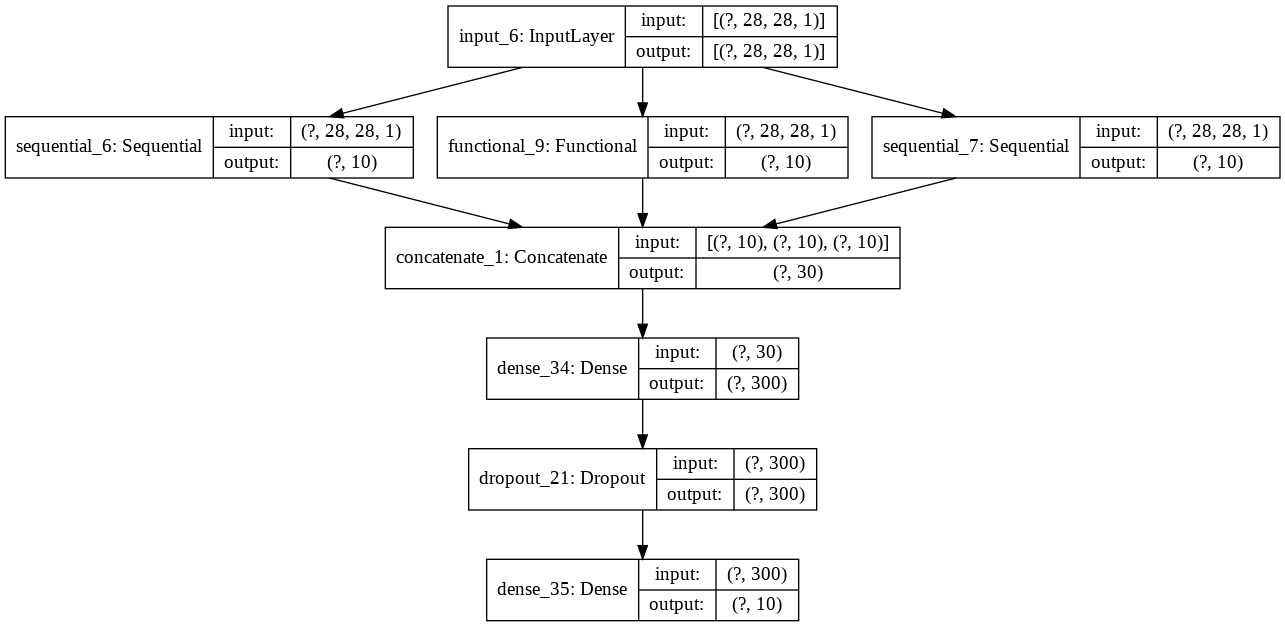

In [74]:
ubermodel = getUberModel(learning_rate, model_A, model_B, model_C)
#ubermodel.summary()
keras.utils.plot_model(ubermodel, "ubermodel.png", show_shapes=True)

In [75]:
#Ubermodel train:
start_time = time.time()
epochs_U, hist_U = train_model(ubermodel, uber_data_norm, uber_labels, epochs+20, batch_size, validation_split, verbose=verbose)

if not submit:
    print("\nTrained model C in about {} seconds\n".format((round(time.time()-start_time,4))))


Epoch 1/50
95/95 [==============================] - 1s 13ms/step - loss: 0.7581 - accuracy: 0.9399 - val_loss: 0.0756 - val_accuracy: 0.9912
Epoch 2/50
95/95 [==============================] - 1s 11ms/step - loss: 0.0278 - accuracy: 0.9989 - val_loss: 0.0459 - val_accuracy: 0.9908
Epoch 3/50
95/95 [==============================] - 1s 11ms/step - loss: 0.0124 - accuracy: 0.9985 - val_loss: 0.0397 - val_accuracy: 0.9924
Epoch 4/50
95/95 [==============================] - 1s 11ms/step - loss: 0.0121 - accuracy: 0.9977 - val_loss: 0.0348 - val_accuracy: 0.9908
Epoch 5/50
95/95 [==============================] - 1s 10ms/step - loss: 0.0154 - accuracy: 0.9961 - val_loss: 0.0485 - val_accuracy: 0.9880
Epoch 6/50
95/95 [==============================] - 1s 11ms/step - loss: 0.0115 - accuracy: 0.9971 - val_loss: 0.0392 - val_accuracy: 0.9896
Epoch 7/50
95/95 [==============================] - 1s 11ms/step - loss: 0.0141 - accuracy: 0.9963 - val_loss: 0.0556 - val_accuracy: 0.9880
Epoch 8/50
95

In [76]:
print ("Ubermodel:",ubermodel.evaluate(val_data_norm, val_labels, batch_size=100))

20/20 [==============================] - 0s 3ms/step - loss: 0.0444 - accuracy: 0.9930
Ubermodel: [0.044363755732774734, 0.9929999709129333]


In [87]:
digiteer = keras.models.load_model(filepath='/content/digiteer_model.zip')

OSError: ignored

In [60]:
def getPredictions(model=None, dataset=None): 
    ''' Takes a trained model and data
        Returns a List of guesses for that model on that data
    ''' 
    predictions = []
    predicts = model.predict(dataset)
    for j in range(len(dataset)):
        probs = predicts[j] # one row of 10 probabilities 
        max_id = np.argmax(probs)   # index of top probability in row
        predictions += [max_id]
    return predictions

In [61]:
def getProbabilities(model=None, dataset=None):
    ''' Takes a trained model and a set of data
        Returns a List of guesses by that model for that data
    ''' 
    return model.predict(dataset)

In [62]:
#kaggle = pd.read_csv('../input/digit-recognizer/test.csv')
kaggle = pd.read_csv('https://github.com/davidabelin/kaggle-files/raw/main/digit-recognizer/test.csv')
kaggle_norm = np.asarray(kaggle/255.)
kaggle_norm = kaggle_norm.reshape(28000, 28, 28, 1)

In [ ]:
kag_guesses = pd.DataFrame(columns=['A', 'B', 'C', 'AB','AC','CB'])

kag_guesses['A'] = getPredictions(model=model3D_A, dataset=kaggle_norm)
kag_guesses['B'] = getPredictions(model=model3D_B, dataset=kaggle_norm)
kag_guesses['C'] = getPredictions(model=model3D_C, dataset=kaggle_norm)

for i in range(len(kag_guesses['A'])):
    kag_guesses['AB'] = kag_guesses['A'] - kag_guesses['B']
    kag_guesses['AC'] = kag_guesses['A'] - kag_guesses['C']
    kag_guesses['CB'] = kag_guesses['C'] - kag_guesses['B']

In [ ]:
kag_probs = pd.DataFrame(columns=list(range(30)))

getProbabilities()
uberguesses = getPredictions(model=ubermodel, )

In [ ]:
if not submit:
#All agree on them all!?
    kag_guesses['CB'].sum() + kag_guesses['AC'].sum() + kag_guesses['AB'].sum()
    kag_guesses.to_csv('guessesABC.csv')

In [ ]:
if submit:
    kaggles = pd.DataFrame(columns=['ImageId','Label']) 
    kaggles['Label'] = kag_guesses['C']
    kaggles['ImageId'] = [i+1 for i in kaggles.index.values] 
    kaggles.to_csv('submission.csv', columns=["ImageId","Label"], index=False)

##Visualizations

In [ ]:
k_img = np.asarray(kaggle.iloc[20044 - 1])
k_img = k_img.reshape(28,28)
plt.imshow(k_img)

In [ ]:
if not submit:
# Plot a graph of the 'accuracy' metric vs. epochs:
    plt.plot(epochs_A,hist_A["accuracy"])
    plt.plot(epochs_A,hist_A["val_accuracy"])
    plt.show()

    plt.plot(epochs_B,hist_B["accuracy"])
    plt.plot(epochs_B,hist_B["val_accuracy"])
    plt.show()